# Computing the optimal statistic with enterprise

In this notebook you will learn how to compute the optimal statistic. The optimal statistic is a frequentist detection statistic for the stochastic background. It assesses the significance of the cross-correlations, and compares them to the Hellings-Downs curve.

For more information, see [Anholm et al. 2009](https://arxiv.org/abs/0809.0701), [Demorest et al. 2013](https://arxiv.org/abs/1201.6641), [Chamberlin et al. 2015](https://arxiv.org/abs/1410.8256), [Vigeland et al. 2018](https://arxiv.org/abs/1805.12188).

This notebook shows you how to compute the optimal statistic for the 12.5yr data set.

## Imports, data loading, and setup

In [1]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
import numpy as np
import pickle
import json
import glob

import matplotlib.pyplot as plt
%matplotlib inline

from enterprise.signals import signal_base
from enterprise.signals import gp_signals
from enterprise.pulsar import Pulsar

from enterprise_extensions import model_utils, blocks
from enterprise_extensions.frequentist import optimal_statistic as opt_stat

import h5py

In [2]:
psrlist = None # define a list of pulsar name strings that can be used to filter.
# set the data directory
datadir = './data'
if not os.path.isdir(datadir):
    datadir = '../data'
print(datadir)

../data


In [3]:
# for the entire pta
parfiles = sorted(glob.glob(datadir + '/par/*par'))
timfiles = sorted(glob.glob(datadir + '/tim/*tim'))

# filter
if psrlist is not None:
    parfiles = [x for x in parfiles if x.split('/')[-1].split('.')[0] in psrlist]
    timfiles = [x for x in timfiles if x.split('/')[-1].split('.')[0] in psrlist]

# Make sure you use the tempo2 parfile for J1713+0747!!
# ...filtering out the tempo parfile... 
parfiles = [x for x in parfiles if 'J1713+0747_NANOGrav_12yv3.gls.par' not in x]

In [4]:
psrs = []
ephemeris = 'DE438'
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t, ephem=ephemeris)
    psrs.append(psr)

In [5]:
# Load up the noise dictionary to get values for the white noise parameters
# Change the noisefile to point to where you have saved the noisefile
noisefile = datadir + '/channelized_12p5yr_v3_full_noisedict.json'

with open(noisefile, 'r') as f:
    noisedict = json.load(f)

In [6]:
%%time
# (Note: It may take a few minutes to run this cell and may require at least ~4GB RAM)
# Initialize the optimal statistic object
# You can give it a list of pulsars and the noise dictionary, and it will create the pta object for you
# Alternatively, you can make the pta object yourself and give it to the OptimalStatistic object as an argument

# find the maximum time span to set GW frequency sampling
Tspan = model_utils.get_tspan(psrs)

# Here we build the signal model
# First we add the timing model
s = gp_signals.TimingModel()

# Then we add the white noise
# There are three types of white noise: EFAC, EQUAD, and ECORR
# We use different white noise parameters for every backend/receiver combination
# The white noise parameters are held constant
s += blocks.white_noise_block(vary=False, inc_ecorr=True, select='backend')

# Next comes the individual pulsar red noise
# We model the red noise as a Fourier series with 30 frequency components, 
# with a power-law PSD
s += blocks.red_noise_block(prior='log-uniform', Tspan=Tspan, components=30)

# Finally, we add the common red noise, which is modeled as a Fourier series with 5 frequency components
# The common red noise has a power-law PSD with spectral index of 4.33
s += blocks.common_red_noise_block(psd='powerlaw', prior='log-uniform', Tspan=Tspan, 
                                   components=5, gamma_val=4.33, name='gw')

# We set up the PTA object using the signal we defined above and the pulsars
pta = signal_base.PTA([s(p) for p in psrs])

# We need to set the white noise parameters to the values in the noise dictionary
pta.set_default_params(noisedict)

ostat = opt_stat.OptimalStatistic(psrs, pta=pta, orf='hd')
ostat_dip = opt_stat.OptimalStatistic(psrs, pta=pta, orf='dipole')
ostat_mono = opt_stat.OptimalStatistic(psrs, pta=pta, orf='monopole')

42599211035
INFO: enterprise.signals.signal_base: Setting J1853+1303_430_ASP_efac to 1.078315248869886
INFO: enterprise.signals.signal_base: Setting J1853+1303_430_PUPPI_efac to 1.0109631461154447
INFO: enterprise.signals.signal_base: Setting J1853+1303_L-wide_ASP_efac to 1.0786110947865066
INFO: enterprise.signals.signal_base: Setting J1853+1303_L-wide_PUPPI_efac to 1.0235843088915801
INFO: enterprise.signals.signal_base: Setting J1853+1303_430_ASP_log10_equad to -7.0316537983149825
INFO: enterprise.signals.signal_base: Setting J1853+1303_430_PUPPI_log10_equad to -7.1227376684628645
INFO: enterprise.signals.signal_base: Setting J1853+1303_L-wide_ASP_log10_equad to -7.1547369968726455
INFO: enterprise.signals.signal_base: Setting J1853+1303_L-wide_PUPPI_log10_equad to -7.722036732168339
INFO: enterprise.signals.signal_base: Setting J1853+1303_430_ASP_log10_ecorr to -6.786182491593548
INFO: enterprise.signals.signal_base: Setting J1853+1303_430_PUPPI_log10_ecorr to -7.344038425120731
IN

In [7]:
# Load up the maximum-likelihood values for the pulsars' red noise parameters and the common red process
# These values come from the results of a Bayesian search (model 2A)
# Once you have done your own Bayesian search, 
# you can make your own parameter dictionary of maximum-likelihood values

with open(datadir + '/12p5yr_maxlike.json', 'r') as f:
    ml_params = json.load(f)

## Optimal statistics with maximum likelihood noise parameters

In [9]:
# Compute the optimal statistic
# The optimal statistic returns five quantities:
#  - xi: an array of the angular separations between the pulsar pairs (in radians)
#  - rho: an array of the cross-correlations between the pulsar pairs
#  - sig: an array of the uncertainty in the cross-correlations
#  - OS: the value of the optimal statistic
#  - OS_sig: the uncertainty in the optimal statistic

xi, rho, sig, OS, OS_sig = ostat.compute_os(params=ml_params)
print(OS, OS_sig, OS/OS_sig)

_, _, _, OS_dip, OS_sig_dip = ostat_dip.compute_os(params=ml_params)
print(OS_dip, OS_sig_dip, OS_dip/OS_sig_dip)

_, _, _, OS_mono, OS_sig_mono = ostat_mono.compute_os(params=ml_params)
print(OS_mono, OS_sig_mono, OS_mono/OS_sig_mono)

4.1055830757992356e-30 1.5284399099773689e-30 2.686126585022257
9.145776043637266e-31 3.999316970912894e-31 2.2868345045303147
8.728806178805702e-31 2.7306118364214677e-31 3.19664848089321


In [10]:
# Plot the cross-correlations and compare to the Hellings-Downs curve
# Before plotting, we need to bin the cross-correlations

def weightedavg(rho, sig):
    weights, avg = 0., 0.
    for r,s in zip(rho,sig):
        weights += 1./(s*s)
        avg += r/(s*s)
        
    return avg/weights, np.sqrt(1./weights)

def bin_crosscorr(zeta, xi, rho, sig):
    
    rho_avg, sig_avg = np.zeros(len(zeta)), np.zeros(len(zeta))
    
    for i,z in enumerate(zeta[:-1]):
        myrhos, mysigs = [], []
        for x,r,s in zip(xi,rho,sig):
            if x >= z and x < (z+10.):
                myrhos.append(r)
                mysigs.append(s)
        rho_avg[i], sig_avg[i] = weightedavg(myrhos, mysigs)
        
    return rho_avg, sig_avg

# sort the cross-correlations by xi
idx = np.argsort(xi)

xi_sorted = xi[idx]
rho_sorted = rho[idx]
sig_sorted = sig[idx]

# bin the cross-correlations so that there are the same number of pairs per bin
npairs = 66

xi_mean = []
xi_err = []

rho_avg = []
sig_avg = []

i = 0
while i < len(xi_sorted):
    
    xi_mean.append(np.mean(xi_sorted[i:npairs+i]))
    xi_err.append(np.std(xi_sorted[i:npairs+i]))

    r, s = weightedavg(rho_sorted[i:npairs+i], sig_sorted[i:npairs+i])
    rho_avg.append(r)
    sig_avg.append(s)
    
    i += npairs
    
xi_mean = np.array(xi_mean)
xi_err = np.array(xi_err)

In [11]:
def get_HD_curve(zeta):
    
    coszeta = np.cos(zeta*np.pi/180.)
    xip = (1.-coszeta) / 2.
    HD = 3.*( 1./3. + xip * ( np.log(xip) -1./6.) )
    
    return HD/2

## Figure 5 (bottom panel)

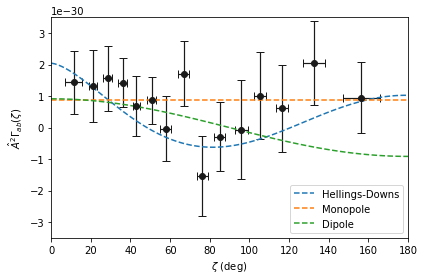

In [12]:
# reproduce the bottom panel of Figure 5 in https://arxiv.org/abs/2009.04496

(_, caps, _) = plt.errorbar(xi_mean*180/np.pi, rho_avg, xerr=xi_err*180/np.pi, yerr=sig_avg, marker='o', ls='', 
                            color='0.1', fmt='o', capsize=4, elinewidth=1.2)

zeta = np.linspace(0.01,180,100)
HD = get_HD_curve(zeta+1)

plt.plot(zeta, OS*HD, ls='--', label='Hellings-Downs', color='C0', lw=1.5)
plt.plot(zeta, zeta*0.0+OS_mono, ls='--', label='Monopole', color='C1', lw=1.5)
plt.plot(zeta, OS_dip*np.cos(zeta*np.pi/180), ls='--', label='Dipole', color='C2', lw=1.5)

plt.xlim(0, 180);
plt.ylim(-3.5e-30, 3.5e-30);
plt.ylabel(r'$\hat{A}^2 \Gamma_{ab}(\zeta)$')
plt.xlabel(r'$\zeta$ (deg)');

plt.legend(loc=4);

plt.tight_layout();
plt.show();

## Noise marginalized optimal statistics
* To compute the noise-marginalized optimal statistic (Vigeland et al. 2018), you will need the chain from a Bayesian search for a common red process without spatial correlations (model 2A).

In [13]:
dldir = '../downloaded_chains/'
if not os.path.exists(dldir):
    os.makedirs(dldir)

In [15]:
# Temporary Google Drive download for the required chain file:
!pip install gdown

In [17]:
!gdown --id 1G0I029nqM9r9Tp5syNErnzlvf9NG34zO -O '../downloaded_chains/12p5yr_DE438_model2a_cRN5freq_gammaFixed4.33_chain.gz'
!gdown --id 12pjntRjJQvL8N0CXCVyGupLV6ARIXPOr -O '../downloaded_chains/12p5yr_DE438_model2a_cRN5freq_gammaFixed4.33_pars.txt'

Downloading...
From: https://drive.google.com/uc?id=1G0I029nqM9r9Tp5syNErnzlvf9NG34zO
To: /Users/aaron/Documents/GitHub/12p5yr_stochastic_analysis/downloaded_chains/12p5yr_DE438_model2a_cRN5freq_gammaFixed4.33_chain.gz
187MB [00:02, 69.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=12pjntRjJQvL8N0CXCVyGupLV6ARIXPOr
To: /Users/aaron/Documents/GitHub/12p5yr_stochastic_analysis/downloaded_chains/12p5yr_DE438_model2a_cRN5freq_gammaFixed4.33_pars.txt
100%|██████████████████████████████████████| 2.52k/2.52k [00:00<00:00, 4.42MB/s]


In [18]:
%%time
# (Note: It may take a few minutes to run this cell)
# Change chaindir to point to where you have the chain from your Bayesian search
chain = np.loadtxt('../downloaded_chains/12p5yr_DE438_model2a_cRN5freq_gammaFixed4.33_chain.gz')
params = np.loadtxt('../downloaded_chains/12p5yr_DE438_model2a_cRN5freq_gammaFixed4.33_pars.txt',                         dtype=np.str)

#or using hdf5 files
# with h5py.File(chaindir + '/chain_1_compressed.hdf5', 'r') as fff:
#     chain = fff['samples'][:,:]
#     params = [S.decode('utf-8') for S in list(fff['params'][:])]
#     print(chain[:,:].shape)
#     print(params[:])

CPU times: user 1min 15s, sys: 838 ms, total: 1min 15s
Wall time: 1min 15s


In [20]:
param_dict = {}
params = list(params)
for p in params:
    param_dict.update({p: np.median(chain[:, params.index(p)])})

with open('../data/12p5yr_median.json', 'w') as f:
    json.dump(param_dict, f)

In [23]:
%%time
# (Note: It may take a few minutes to run this cell)
N = 1000   # number of times to compute the optimal statistic - official analysis used 10k - you can increase this if you don't mind the extra runtime
burn = int(0.25*chain.shape[0])   # estimate of when the chain has burned in

noisemarg_OS, noisemarg_OS_err = np.zeros(N), np.zeros(N)
noisemarg_OS_dip, noisemarg_OS_dip_err = np.zeros(N), np.zeros(N)
noisemarg_OS_mono, noisemarg_OS_mono_err = np.zeros(N), np.zeros(N)

for i in range(N):
    if i%100==0:
        print("Status: ", i, "/", N, " -- ", i/N*100, " %")
    # choose a set of noise values from the chain
    # make sure that you pull values from after the chain has burned in
    idx = np.random.randint(burn, chain.shape[0])
    
    # construct a dictionary with these parameter values
    param_dict = {}
    for p in params:
        param_dict.update({p: chain[idx, params.index(p)]})
    
    # compute the optimal statistic at this set of noise values and save in an array
    _, _, _, noisemarg_OS[i], noisemarg_OS_err[i] = ostat.compute_os(params=param_dict)
    _, _, _, noisemarg_OS_dip[i], noisemarg_OS_dip_err[i] = ostat_dip.compute_os(params=param_dict)
    _, _, _, noisemarg_OS_mono[i], noisemarg_OS_mono_err[i] = ostat_mono.compute_os(params=param_dict)

Status:  0 / 1000  --  0.0  %
Status:  100 / 1000  --  10.0  %
Status:  200 / 1000  --  20.0  %
Status:  300 / 1000  --  30.0  %
Status:  400 / 1000  --  40.0  %
Status:  500 / 1000  --  50.0  %
Status:  600 / 1000  --  60.0  %
Status:  700 / 1000  --  70.0  %
Status:  800 / 1000  --  80.0  %
Status:  900 / 1000  --  90.0  %
CPU times: user 29min 39s, sys: 5min 5s, total: 34min 44s
Wall time: 4min 41s


## Figure 4 (bottom panel)

Text(0, 0.5, 'PDF')

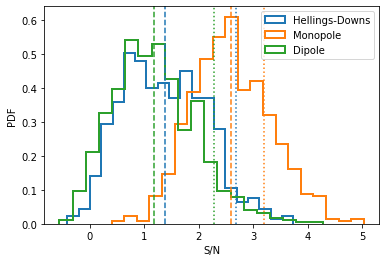

In [24]:
plt.hist(noisemarg_OS/noisemarg_OS_err, histtype='step', lw=2, label='Hellings-Downs', color='C0',
         bins=20, density=True)
plt.hist(noisemarg_OS_mono/noisemarg_OS_mono_err, histtype='step', lw=2, label='Monopole', color='C1',
         bins=20, density=True)
plt.hist(noisemarg_OS_dip/noisemarg_OS_dip_err, histtype='step', lw=2, label='Dipole', color='C2',
         bins=20, density=True)

plt.gca().axvline(x=np.mean(noisemarg_OS/noisemarg_OS_err), ls='--', color='C0')
plt.gca().axvline(x=np.mean(noisemarg_OS_mono/noisemarg_OS_mono_err), ls='--', color='C1')
plt.gca().axvline(x=np.mean(noisemarg_OS_dip/noisemarg_OS_dip_err), ls='--', color='C2')

plt.gca().axvline(x=OS/OS_sig, ls=':', color='C0')
plt.gca().axvline(x=OS_mono/OS_sig_mono, ls=':', color='C1')
plt.gca().axvline(x=OS_dip/OS_sig_dip, ls=':', color='C2')

plt.legend(loc="upper right")
plt.xlabel("S/N")
plt.ylabel("PDF")

## Figure 4 (top panel)

Text(0, 0.5, 'PDF')

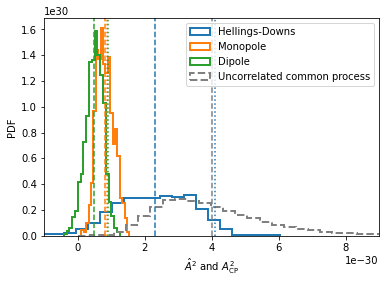

In [25]:
plt.hist(noisemarg_OS, histtype='step', lw=2, label='Hellings-Downs', color='C0', bins=20, density=True)
plt.hist(noisemarg_OS_mono, histtype='step', lw=2, label='Monopole', color='C1', bins=20, density=True)
plt.hist(noisemarg_OS_dip, histtype='step', lw=2, label='Dipole', color='C2', bins=20, density=True)
plt.hist((10**(chain[:,params.index("gw_log10_A")]))**2, histtype='step', lw=2, label='Uncorrelated common process',
         color='grey', ls='--', bins=50, density=True)

plt.gca().axvline(x=np.mean(noisemarg_OS), ls='--', color='C0')
plt.gca().axvline(x=np.mean(noisemarg_OS_mono), ls='--', color='C1')
plt.gca().axvline(x=np.mean(noisemarg_OS_dip), ls='--', color='C2')
plt.gca().axvline(x=np.mean(10**(2*chain[:,params.index("gw_log10_A")])), ls='--', color='grey')

plt.gca().axvline(x=OS, ls=':', color='C0')
plt.gca().axvline(x=OS_mono, ls=':', color='C1')
plt.gca().axvline(x=OS_dip, ls=':', color='C2')

plt.xlim((-1e-30, 9e-30))
plt.legend(loc="upper right")
plt.xlabel(r'$\hat{A}^2$ and $A^2_{\rm CP}$')
plt.ylabel("PDF")